## Change Log
- Experiments can be setup by using the config parameter "experiment_variable" and assigning the experiment values as a list
- E.g. 
    - experiment_variable = "train_val_split"
    - config["training"]["train_val_split"] = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
- note: only parameters of the category "training" and "model_param" can be used

In [1]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math

import sys
import os
sys.path.append(os.getcwd() + "/pytorch_tabnet/")

from sklearn.cluster import DBSCAN
from scipy.special import rel_entr

## 0. Experiment Setup

In [4]:
# should an output folder be created to save the experiment data?
save_output = False
save_models = False

In [6]:
# read config file
import toml
config = toml.load("config.toml")

experiment_variable_values = ""
experiment_dict_key = ""
for category_name, category_values in config.items():
    if config["general"]["experiment_variable"] in category_values:
        experiment_variable_values = category_values[config["general"]["experiment_variable"]]
        experiment_dict_key = category_name
        
# rnd seed to support reproducable results
seed_value =  config["general"]["random_seed"] if config["general"]["random_seed"] else random.randrange(2**32 -1)
random.seed(seed_value)
np.random.seed(seed_value)

# TabNet hyperparameters
experiment_variable = config["general"]["experiment_variable"]
regressor_param = {"optimizer_fn" : torch.optim.Adam,
                   "optimizer_params" : {"lr":0.05},
                   "scheduler_params" : {"step_size": 2, "gamma": 0.9},
                   "scheduler_fn" : torch.optim.lr_scheduler.StepLR,
                   "mask_type" : 'entmax',
                   "device_name" : 'cuda', # only working on NVIDIA GPUs
                   "verbose" : 0
                  }

if save_output or save_models:
    # create experiment folder
    from datetime import datetime
    
    experiment_name = config["general"]["experiment_name"]
    experiment_folder = f"{experiment_name} {datetime.now().strftime('%Y_%m_%d %H-%M-%S')}" if experiment_name else f"{config['RQ2']['runs']}_runs_{config['general']['experiment_variable']} {datetime.now().strftime('%Y_%m_%d %H-%M-%S')}"
    
    experiment_path = os.path.join("Experiments", experiment_folder)
    os.mkdir(experiment_path)
    
    plots_path = os.path.join(experiment_path, "plots")
    os.mkdir(plots_path)
    
    models_path = os.path.join(experiment_path, "models")
    os.mkdir(models_path)
    
    # save config file
    import shutil
    shutil.copy2("config.toml", experiment_path)
    
    # save random seed
    if not config["general"]["random_seed"]:
        config["general"]["random_seed"] = seed_value
        config_path = os.path.join(experiment_path, "config.toml")
        with open(config_path, "w") as f:
            toml.dump(config, f)
    
    # save model hyperparameters
    with open(os.path.join(experiment_path, 'config.toml'), 'a') as config_file:
        config_file.write("\n#[regressor_param]\n")
        for key, value in regressor_param.items(): 
            config_file.write('#%s = %s\n' % (key, str(value)))
    
    # save notebook
    shutil.copy2(nb_name, experiment_path)
    
    # create output file
    output_path = os.path.join(experiment_path, "output.toml")
    output_file = open(output_path, "w")

output = {}

## 1. Datasets

Different datasets are to be used for the experiments.
- toy dataset using make_blobs from sklearn mainly to setup and test the notebook
- DAMI Benchmark datasets with the respective best practice hyperparameters (https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/)

### 1.0. Create toy dataset
As of now, only a toy dataset is used (n_features features with clusters centered around different points).

In [7]:
from sklearn.datasets import make_blobs

if config["general"]["use_toy_data"]:
    features_arr, clusters_arr = make_blobs(**config["toy_data"], random_state=seed_value)

    # name feature and cluster (ground truth) columns
    features = pd.DataFrame(features_arr, columns=[f"F{x + 1}" for x in range(features_arr.shape[1])])
    clusters = pd.DataFrame(clusters_arr, columns=["C"])

In [8]:
# plot dataset
if config["general"]["use_toy_data"]:
    %matplotlib notebook
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(features_arr[:, 0], features_arr[:, 1], features_arr[:, 2], c=clusters_arr)
    plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
    plt.show()
    if save_output:
        plt.savefig(os.path.join(plots_path, "0_ground_truth_clusters.png"), **config["plots"])

### 1.1. Use existing datasets

In [70]:
if not config["general"]["use_toy_data"]:
    
    from sklearn.datasets import load_wine
    from sklearn.preprocessing import scale, StandardScaler
    
    wine = load_wine()
    features_unscaled, clusters= pd.DataFrame(wine.data, columns=wine['feature_names']), wine.target
    features = pd.DataFrame(StandardScaler().fit_transform(features_unscaled), columns=wine['feature_names'])

### 1.2. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [12]:
# create missing values in feature column(s)
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(features.columns), config["general"]["missing_percent"])}
features_mv = features.copy()

for f, mv in mv_config.items():
    features_mv[f] = features_mv[f].mask(np.random.random(features.shape[0]) < mv)

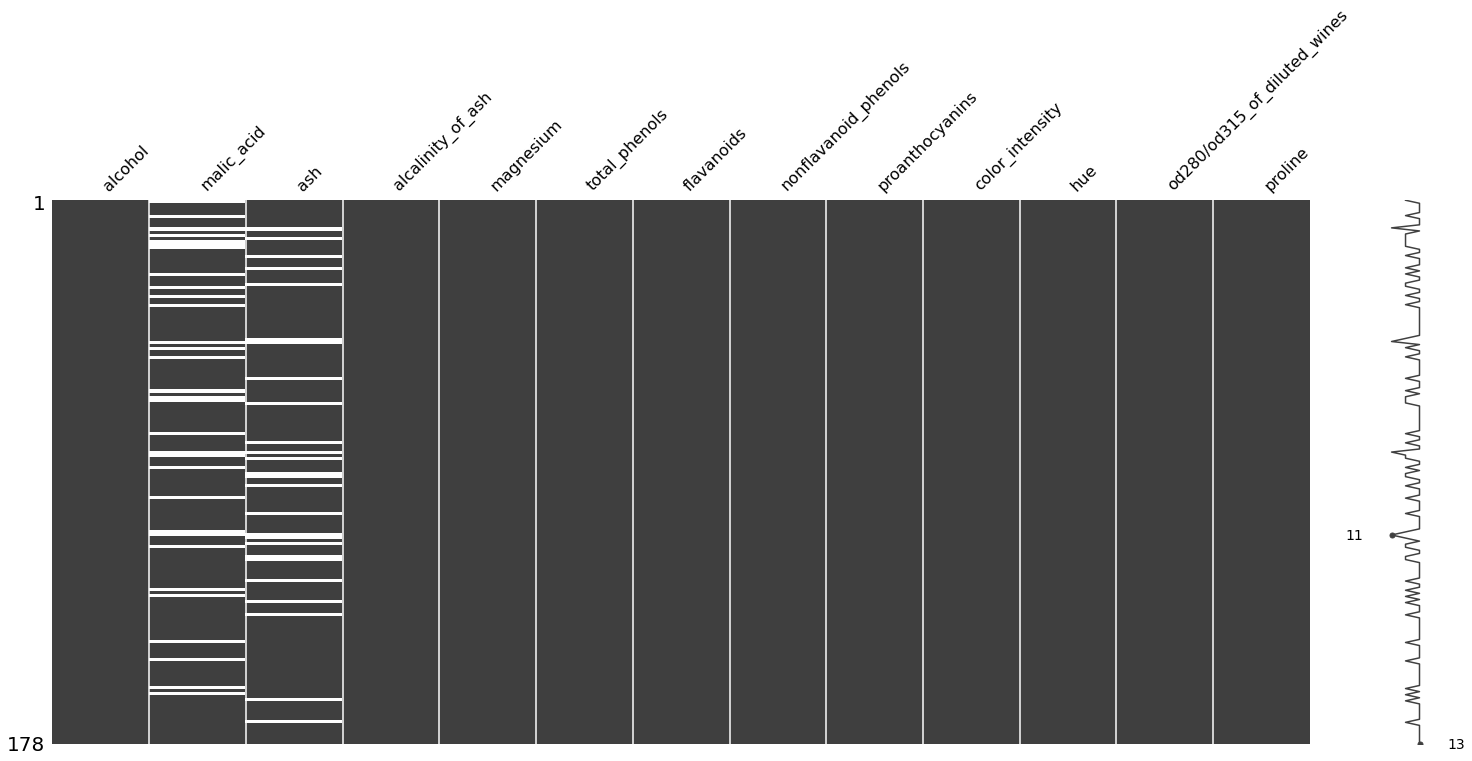

In [13]:
import missingno as msno
%matplotlib inline

# plot missing values
fig = msno.matrix(features_mv)
plt.show()
if save_output:
    #plt.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"])
    fig_copy = fig.get_figure()
    fig_copy.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"], bbox_inches = 'tight')

### 1.3. Initial Clustering (without missing values)
Automatically determine DBSCAN hyperparameters min_samples and eps.

Use the cluster algorithm on dataset without missing values.

In [14]:
# run DBSCAN on original data
dbscan_orig = DBSCAN(**config["DBSCAN"]).fit(features)
clusters_orig = dbscan_orig.labels_

In [15]:
# plot clustering
%matplotlib notebook
if config["general"]["use_toy_data"]:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(features.iloc[:, 0], features.iloc[:, 1], features.iloc[:, 2], c=clusters_orig)
    plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
    plt.show()
    if save_output:
        plt.savefig(os.path.join(plots_path, "1_DBSCAN_original_data.png"), **config["plots"])

Get cluster means for loss function input.

In [13]:
# get cluster means (used to calculate the cluster mean loss)
complete_data = features.copy()
complete_data["C"] = clusters_orig
cluster_means = complete_data.groupby("C").agg("mean")
cluster_means = cluster_means if -1 not in cluster_means.index else cluster_means.drop(-1)

## 2. Filling Strategies


### 2.1. Define custom-loss
The loss function for the model fitting shall be customized to improve cluster perforamnce. The custom loss is divided into 2 separate losses

1. **Reconstruction Loss**\
Classic loss function, such as RMSE.
2. **Cluster-Mean Loss**\
The distance to the nearest cluster mean shall be minimized.
3. **KL Divergence Loss**\
Deviation of original distribution shall be minimized \
(prob distribution based on https://stackoverflow.com/questions/57687458/how-to-calculate-probabilities-using-numpy-histogram-and-then-use-it-for-calcula \
number of bins: D. Freedman & P. Diaconis (1981) “On the histogram as a density estimator: L2 theory”. Probability Theory and Related Fields 57 (4): 453-476)

The chosen approach to implement the cluster-mean loss is as follows:\
**Adapt the loss function** to calculate a distance to each cluster. The minimum distance (to the nearest cluster) will be used as a cluster-mean-loss. Minimizing this loss should result in the data point moving closer to the nearest cluster mean.\
Potential Problem: loss functions currently work with y_true (true values) and y_score (predicted values). Calculating the distance would require all features. Calculating only the 1 dimensional distance will result in missing values being put into wrong clusters - depending on the first estimate.

In [14]:
# define custom loss function: extend L2-loss by cluster-mean-loss

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error
import astropy.stats

class custom_loss(Metric):

    def __init__(self):
        self._name = "custom_loss"
        self._maximize = False

    def __call__(self, y_true, y_score, cluster_means, target_feature, x_val, y_val):
        # reconstruction loss
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        
        # cluster mean loss
        cml = self.cluster_mean_loss(cluster_means, y_score, target_feature, x_val, y_val)
        
        # KL divergence loss
        bins = len(astropy.stats.freedman_bin_width(y_true.reshape(1,-1)[0], return_bins=True)[1])
        distr1, distr2 = self.probability_dist(y_score, y_true, bins)
        KLdl = torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()
        
        # total loss
        custom_loss = rmse + KLdl + cml
        return custom_loss
    
    # calculate sum of distances to the closest cluster mean
    def cluster_mean_loss(self, cluster_means, y_score, target_feature, x_val, y_val):
        
        # reorder cluster_means to match x_val columns (predicted feature is last column)
        cols = cluster_means.columns.tolist()
        feature_col = features.columns.get_loc(target_feature)
        cols = cols[:feature_col] + cols[feature_col+1:] + [target_feature]
        
        # x values extended by predicted values
        x_extended = pd.DataFrame(np.hstack((x_val, y_score)), columns=cols)


        # calculate distances to each cluster and select the closest one
        dist = []
        for cluster in range(cluster_means.shape[0]):
            dist.append(np.linalg.norm((x_extended - cluster_means.iloc[cluster]), axis=1))
            
        dist = pd.DataFrame(dist).T
        min_dist = dist.assign(min_dist=lambda d: d.min(1))["min_dist"]
        
        return sum(min_dist)
    
    # calculate probabilities
    def probability_dist(self, x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(np.asarray(x)[:,0], np.asarray(y)[:,0], bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

### 2.2. Fill missing values (TabNet).

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
&rarr; one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

In [15]:
import time

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

features_to_predict = features_mv.columns[features_mv.isnull().any()]
features_reconstr = {}
output["costs"] = {}
output["runtimes"] = {}

for run in range(config["RQ2"]["runs"]):
    
    print(f"Run {run + 1} / {config['RQ2']['runs']}")
    features_reconstr[run] = []
    output["costs"][f"run_{run}"] = {}
    output["runtimes"][f"run_{run}"] = {}
    
    for i, experiment_value in enumerate(experiment_variable_values):
        
        config[experiment_dict_key][config["general"]["experiment_variable"]] = experiment_value
        
        time_start = time.time()
        features_reconstr[run].append(features_mv.copy())
        output["costs"][f"run_{run}"][str(experiment_value)] = {}
        output["runtimes"][f"run_{run}"][str(experiment_value)] = {}
        
        for feature in features_to_predict:
            
            # select % of features for prediction based on pred_features (e.g. 10% of randomly selected features)
            number_of_features = math.ceil(config["RQ2"]["pred_features"] * (len(features_mv.columns)) - 1)
            features_mv_masked = features_mv.copy().drop(feature, axis=1).sample(n=number_of_features, axis='columns')
            selected_features = features_mv_masked.columns

            # mask other columns' missing values as defined in config (missing_value_mask)
            features_mv_masked[feature] = features_mv[feature]
            features_mv_masked[selected_features] = features_mv_masked[(selected_features)].fillna(config["general"]["missing_value_mask"])

            # separate complete rows as train data
            # separate column with missing values as target
            test_data = features_mv_masked[features_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
            train_data = features_mv_masked[features_mv_masked[feature].notna()]
            train_features = train_data.drop(columns=feature).to_numpy()
            train_target = train_data[feature].to_numpy().reshape(-1,1)

            x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, train_size=config["training"]["train_val_split"])

            # create & train model
            model = TabNetRegressor(**regressor_param)
            if config["model_param"]["eval_metric"] == ["custom_loss"]:
                model.fit(
                    x_train, y_train,
                    eval_set=[(x_val, y_val)],
                    **config["model_param"],
                    cluster_means=cluster_means,
                    target_feature=feature,
                    x_val=x_val,
                    y_val=y_val,
                )
            else:
                model.fit(
                    x_train, y_train,
                    eval_set=[(x_val, y_val)],
                    **config["model_param"]
                )     

            #track runtime
            time_end = time.time()

            # add costs to dict
            output["costs"][f"run_{run}"][str(experiment_value)][feature] = model.best_cost


            # fill missing values with model predictions
            features_reconstr[run][i].loc[features_reconstr[run][i][feature].isna(), feature] = [x[0] for x in model.predict(test_data)]

            # save outputs
            if save_models:

                # save model
                torch.save(model, os.path.join(models_path, f"Model_run{run}_{config['general']['experiment_variable']}{experiment_value}_{feature}.pt"))
            
            if save_output:
                # save runtimes
                output["runtimes"][f"run_{run}"][str(experiment_value)][feature] = time_end - time_start


Run 1 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 4.26719
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 3.08981
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 3.01536
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 1.91532
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 2.91314
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 1.99103
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch 


Early stopping occurred at epoch 369 with best_epoch = 319 and best_val_0_rmse = 2.18406
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 400 with best_epoch = 399 and best_val_0_rmse = 1.53691
Best weights from best epoch are automatically used!
Run 5 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 2.64171
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 18 and best_val_0_rmse = 2.99461
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 1.90631
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 2.06472
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best


Early stopping occurred at epoch 142 with best_epoch = 92 and best_val_0_rmse = 2.99397
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 348 and best_val_0_rmse = 1.67651
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 248 with best_epoch = 198 and best_val_0_rmse = 1.95812
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 208 with best_epoch = 158 and best_val_0_rmse = 1.7647
Best weights from best epoch are automatically used!
Run 9 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 3.8775
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 2.09792
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 3


Early stopping occurred at epoch 141 with best_epoch = 91 and best_val_0_rmse = 3.14019
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 254 with best_epoch = 204 and best_val_0_rmse = 1.23918
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rmse = 2.29767
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 329 and best_val_0_rmse = 1.67287
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 181 with best_epoch = 131 and best_val_0_rmse = 2.68897
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 280 with best_epoch = 230 and best_val_0_rmse = 1.81356
Best weights from best epoch are automatically used!
Run 13 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 2.91973
Be

Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.294
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 231 with best_epoch = 181 and best_val_0_rmse = 1.82208
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 299 and best_val_0_rmse = 2.60986
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 248 with best_epoch = 198 and best_val_0_rmse = 1.92491
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rmse = 2.14151
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 221 with best_epoch = 171 and best_val_0_rmse = 1.84505
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 214 with best_epoch = 164 and best_val_0_rmse = 1.71359
Best weights fr

Stop training because you reached max_epochs = 200 with best_epoch = 170 and best_val_0_rmse = 2.76757
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 180 and best_val_0_rmse = 2.05478
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.51678
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 215 and best_val_0_rmse = 2.09834
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 254 with best_epoch = 204 and best_val_0_rmse = 3.58017
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 298 with best_epoch = 248 and best_val_0_rmse = 1.88444
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rm

Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 2.12805
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 3 and best_val_0_rmse = 10.21311
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 2.08016
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.6263
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.85694
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 265 with best_epoch = 215 and best_val_0_rmse = 2.27537
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 230 with best_epoch = 180 and best_val_0_rmse = 2.20529
Bes

Stop training because you reached max_epochs = 150 with best_epoch = 127 and best_val_0_rmse = 3.19514
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 2.39172
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 3.13993
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 178 and best_val_0_rmse = 1.93738
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.50169
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 221 with best_epoch = 171 and best_val_0_rmse = 1.45608
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 254 with best_epoch = 204 and best_val_0_rm

Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 2.93493
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 2.64343
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 3.34546
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 2.67562
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 196 and best_val_0_rmse = 2.92236
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 2.51201
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 188 with best_epoch = 138 and be


Early stopping occurred at epoch 275 with best_epoch = 225 and best_val_0_rmse = 2.07155
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 400 with best_epoch = 399 and best_val_0_rmse = 1.69676
Best weights from best epoch are automatically used!
Run 36 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 3.31102
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 3.75915
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 3.78097
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 2.41041
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch

Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rmse = 2.03153
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rmse = 1.67931
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 28 and best_val_0_rmse = 4.13515
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 280 with best_epoch = 230 and best_val_0_rmse = 1.90755
Best weights from best epoch are automatically used!
Run 40 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 3.00163
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 2.82179
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 129 and best

Stop training because you reached max_epochs = 300 with best_epoch = 299 and best_val_0_rmse = 2.33943
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 299 and best_val_0_rmse = 1.67972
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 179 with best_epoch = 129 and best_val_0_rmse = 2.41556
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rmse = 1.64637
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 400 with best_epoch = 390 and best_val_0_rmse = 2.74617
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 265 with best_epoch = 215 and best_val_0_rmse = 1.9734
Best weights from best epoch are automatically used!
Run 44 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and be


Early stopping occurred at epoch 237 with best_epoch = 187 and best_val_0_rmse = 2.15735
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.03905
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 299 and best_val_0_rmse = 1.90237
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 255 and best_val_0_rmse = 1.64438
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 267 with best_epoch = 217 and best_val_0_rmse = 2.43638
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 249 with best_epoch = 199 and best_val_0_rmse = 1.80352
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 359 with best_epoch = 309 and best_val_0_rmse = 2.94544
Best weights 

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 2.61669
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 172 with best_epoch = 122 and best_val_0_rmse = 1.73949
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.36892
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.48409
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 266 with best_epoch = 216 and best_val_0_rmse = 2.21188
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 285 with best_epoch = 235 and best_val_0_rmse = 1.91769
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 346 and best_val_0_rmse = 1.97946


Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 3.40514
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 1.80401
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 3.41901
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 177 and best_val_0_rmse = 2.28083
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.87826
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.29178
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 221 with best_epoch = 171 and 

Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 4.60413
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 3.30944
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 136 and best_val_0_rmse = 3.73138
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 2.1536
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 2.76002
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 2.34192
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 12 and best_


Early stopping occurred at epoch 237 with best_epoch = 187 and best_val_0_rmse = 1.98693
Best weights from best epoch are automatically used!
Run 63 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 4.02983
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 4.04925
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 3.27749
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 2.54139
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 3.02511
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch

Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rmse = 1.6306
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 400 with best_epoch = 388 and best_val_0_rmse = 2.66894
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 400 with best_epoch = 395 and best_val_0_rmse = 1.6004
Best weights from best epoch are automatically used!
Run 67 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 3.38962
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 2.15913
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 2.58331
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with

Stop training because you reached max_epochs = 300 with best_epoch = 298 and best_val_0_rmse = 1.60926
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 238 with best_epoch = 188 and best_val_0_rmse = 2.71241
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rmse = 1.77831
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 259 with best_epoch = 209 and best_val_0_rmse = 2.33933
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 329 with best_epoch = 279 and best_val_0_rmse = 1.62017
Best weights from best epoch are automatically used!
Run 71 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 4.11645
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse

Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.09664
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 299 and best_val_0_rmse = 2.73208
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 255 and best_val_0_rmse = 2.26649
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 345 and best_val_0_rmse = 2.22124
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rmse = 1.941
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 243 with best_epoch = 193 and best_val_0_rmse = 3.07289
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 290 with best_epoch = 240 and best_val_0_rmse

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 1.91735
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.25629
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 233 and best_val_0_rmse = 1.4529
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 202 with best_epoch = 152 and best_val_0_rmse = 2.83556
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 299 and best_val_0_rmse = 1.64382
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 172 with best_epoch = 122 and best_val_0_rmse = 3.5049
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 335 and best_val_0_rmse

Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 1.77631
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_val_0_rmse = 2.66335
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 2.30726
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.34434
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.20635
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 299 and best_val_0_rmse = 2.35926
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epo

Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 3.01103
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 3.14099
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 1.80486
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 195 and best_val_0_rmse = 2.63936
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 1.62005
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 2.62241
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 183 with best_epoch = 133 and b


Early stopping occurred at epoch 212 with best_epoch = 162 and best_val_0_rmse = 2.10263
Best weights from best epoch are automatically used!
Run 90 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 3.3261
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 3.57984
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 104 and best_val_0_rmse = 3.63388
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 2.46907
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_val_0_rmse = 2.32692
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch 

Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rmse = 2.1049
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 251 with best_epoch = 201 and best_val_0_rmse = 2.05475
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 400 with best_epoch = 399 and best_val_0_rmse = 1.9026
Best weights from best epoch are automatically used!
Run 94 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 3.59535
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 2.94133
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_val_0_rmse = 3.4025
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 

Stop training because you reached max_epochs = 300 with best_epoch = 299 and best_val_0_rmse = 1.78485
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rmse = 2.12897
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 350 with best_epoch = 349 and best_val_0_rmse = 1.87174
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 400 with best_epoch = 399 and best_val_0_rmse = 2.39695
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 248 with best_epoch = 198 and best_val_0_rmse = 1.89883
Best weights from best epoch are automatically used!
Run 98 / 100
Stop training because you reached max_epochs = 100 with best_epoch = 78 and best_val_0_rmse = 3.22418
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoc

## 3. Complete Dataset
Costs for each run

### 3.1 Reconstruct Dataset
choose best model based on min. squared custom loss (punishing large outliers in losses for single features)

In [40]:
best_per_run = []
best_per_run_index = []
for run in range(config["RQ2"]["runs"]):
    cost_list = list(output["costs"][f"run_{run}"].values())
    cost_totals = [sum(c**2 for c in list(x.values())) for x in cost_list]
    best_per_run.append(min(cost_totals))
    best_per_run_index.append(cost_totals.index(min(cost_totals)))
    
best_run = best_per_run.index(min(best_per_run))
best_model = best_per_run_index[best_run]
print(f"Best model: run {best_run} model {best_model}")

features_best = features_reconstr[best_run][best_model]

Best model: run 15 model 6


### 3.2 Plot changes (comp. to original data)

<IPython.core.display.Javascript object>


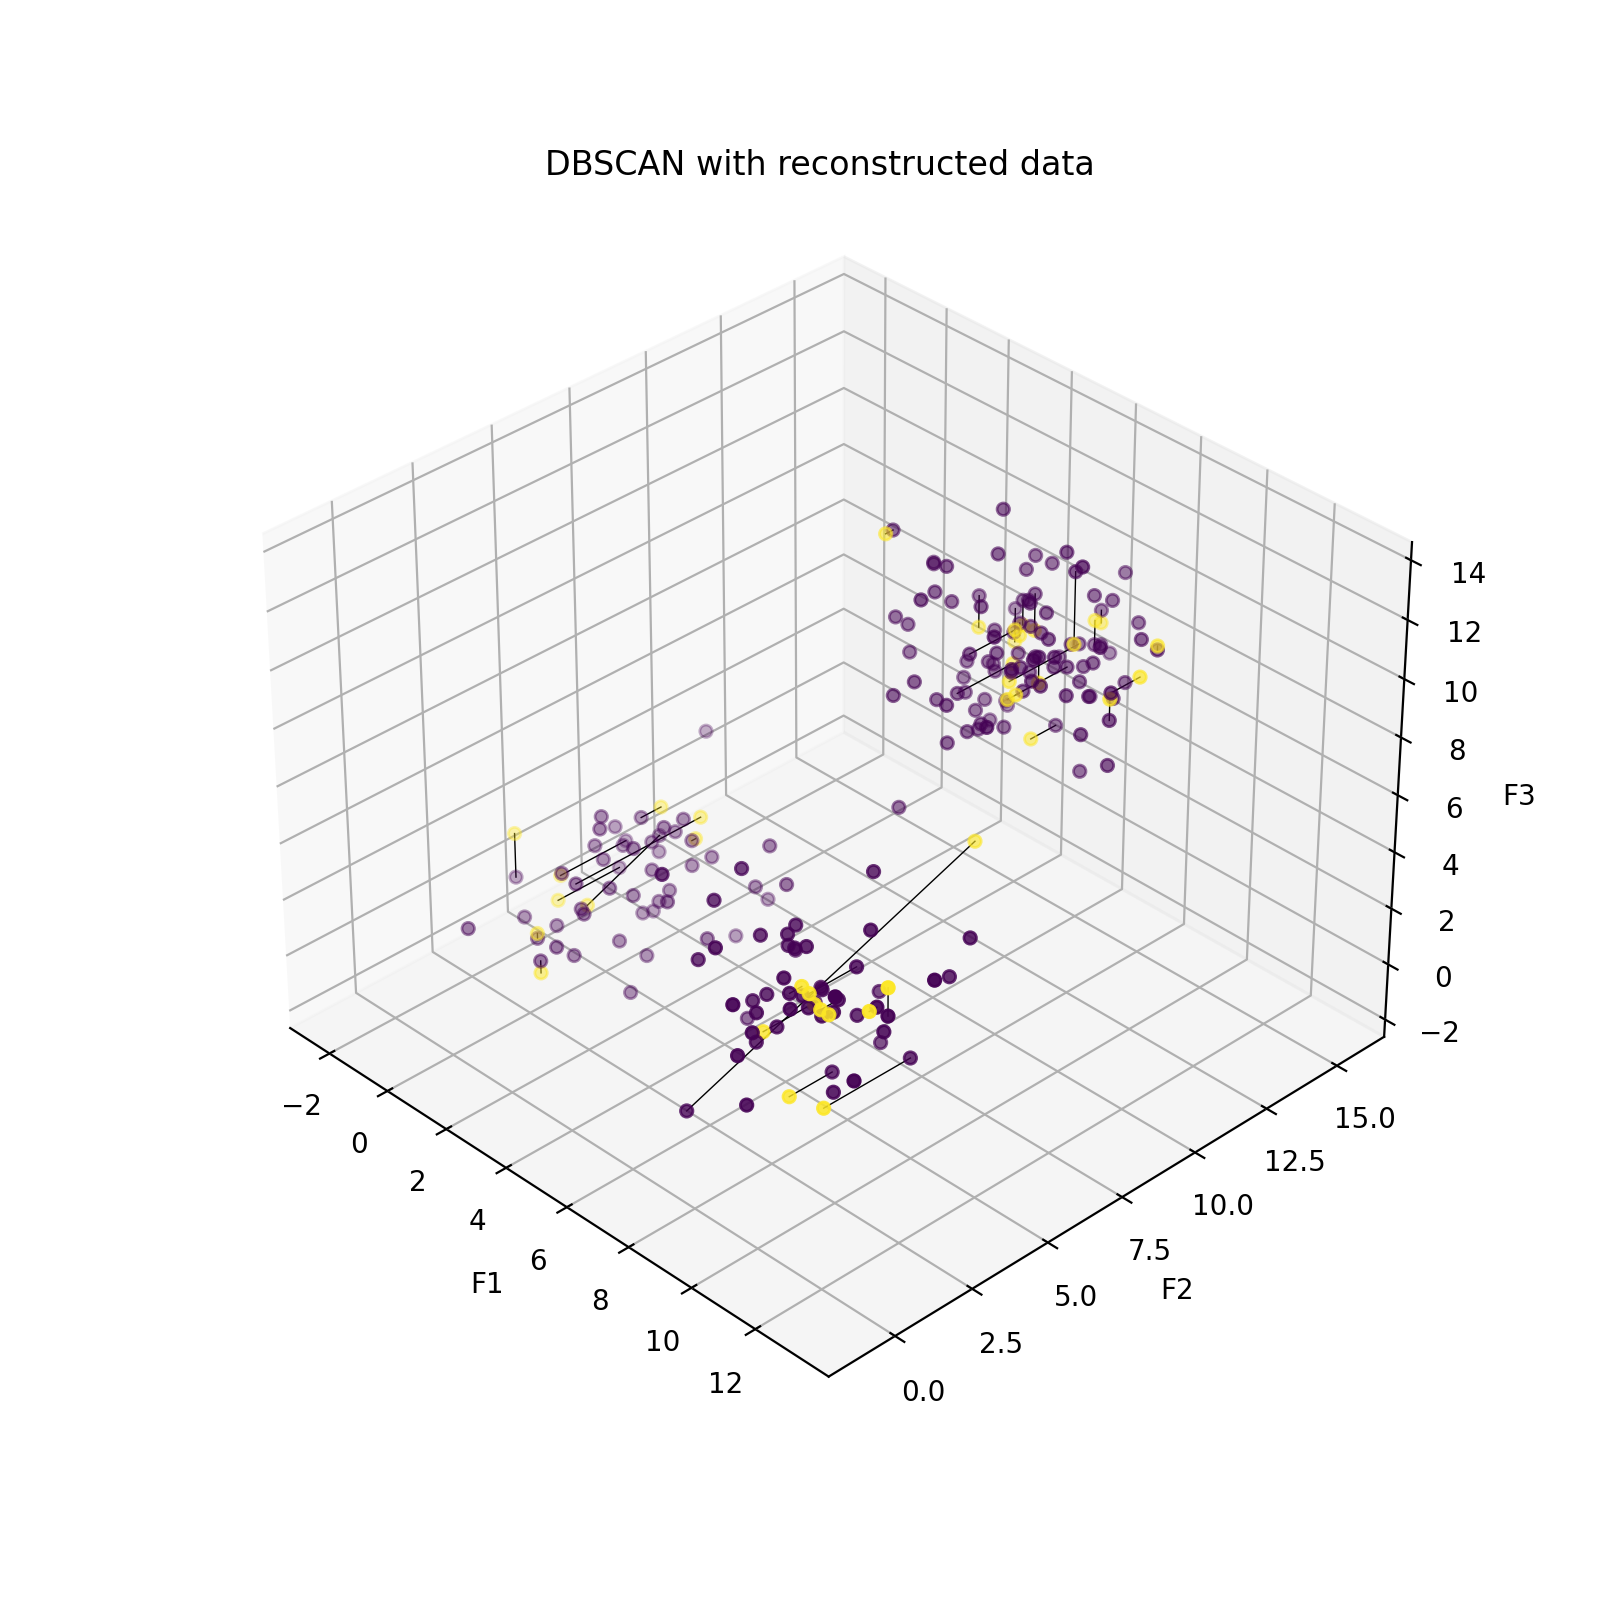

In [41]:
# scatter plot with combined data
orig_data = features.copy()
orig_data["change"] = 0
changed_data = features_best[features_mv.isna().any(axis=1)]
comp_data = pd.concat([orig_data, changed_data]).reset_index(drop=True).fillna(1)

# line plot connecting filled data to true data points
reconstr_data = features_best[features_mv.isna().any(axis=1)]
true_data = features[features_mv.isna().any(axis=1)]

# plot
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection = '3d')
ax.scatter(comp_data["F1"], comp_data["F2"], comp_data["F3"], c=[comp_data["change"]])

for i in range(len(reconstr_data)):
    ax.plot([reconstr_data["F1"].iloc[i], true_data["F1"].iloc[i]],[reconstr_data["F2"].iloc[i], true_data["F2"].iloc[i]],[reconstr_data["F3"].iloc[i], true_data["F3"].iloc[i]], color="black", linewidth=.5)


plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show
if save_output:
    plt.savefig(os.path.join(plots_path, "4_imputation_differences.png"), **config["plots"])

## 4. Clustering

In [42]:
# apply clustering
clusters_reconstr = []
for run in range(config["RQ2"]["runs"]):
    clusters_reconstr.append([])
    for i, var in enumerate(experiment_variable_values):
        dbscan_reconstr = DBSCAN(**config["DBSCAN"]).fit(features_reconstr[run][i])
        clusters_reconstr[run].append(dbscan_reconstr.labels_)

### 4.1. Plot of clustering based on best model predictions

<IPython.core.display.Javascript object>


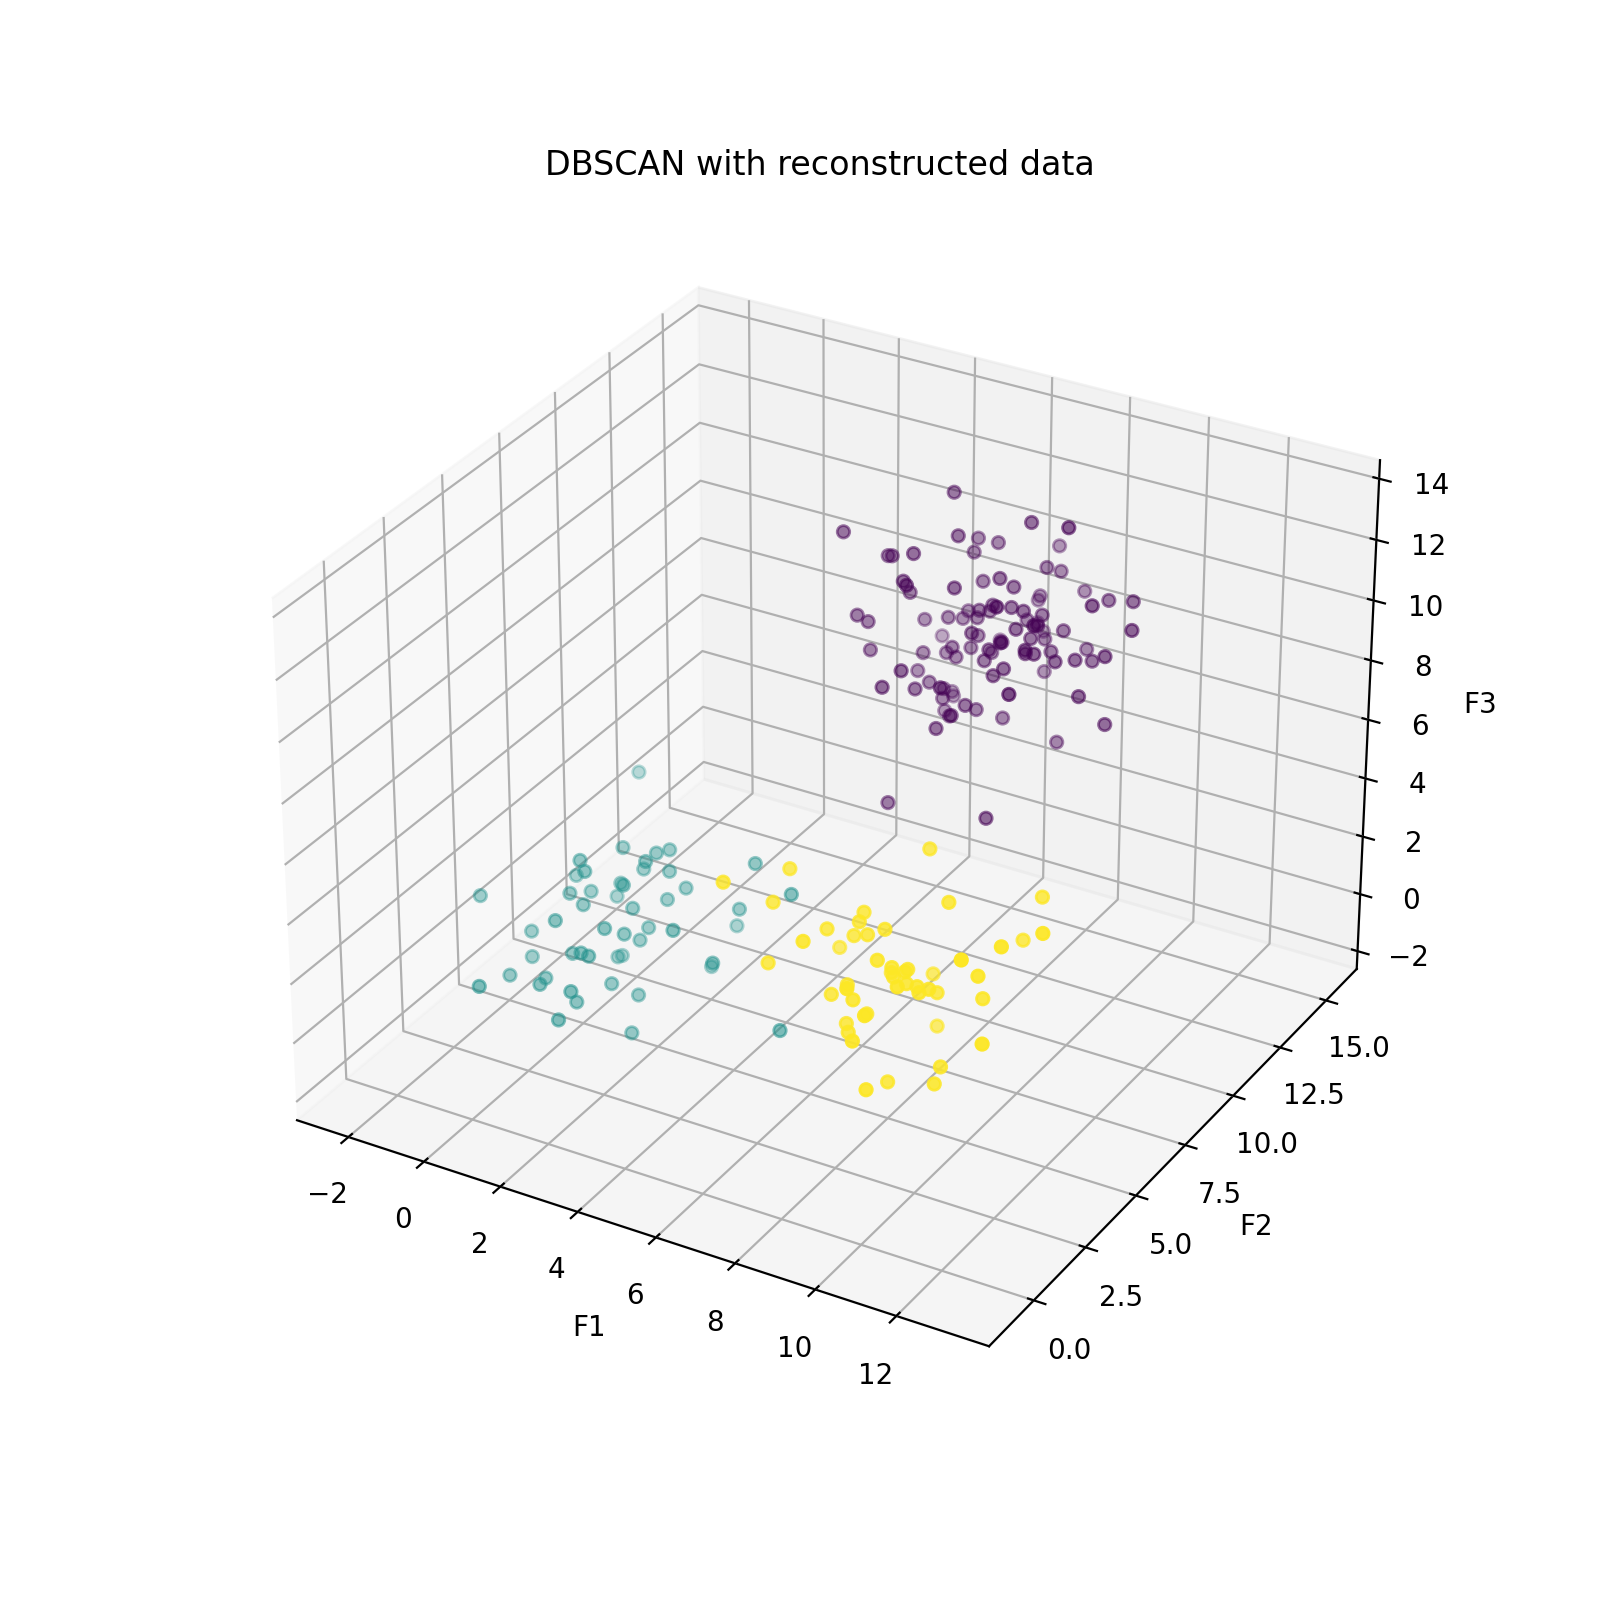

In [43]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_reconstr[best_run][best_model].iloc[:, 0], features_reconstr[best_run][best_model].iloc[:, 1], features_reconstr[best_run][best_model].iloc[:, 2], c=clusters_reconstr[best_run][best_model])
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "3_DBSCAN_imputed_data.png"), **config["plots"])

## 5. Cluster Performance


### 5.1 Feature Distributions
#### 5.1.1 Distr. Plots based on best model predictions

<IPython.core.display.Javascript object>


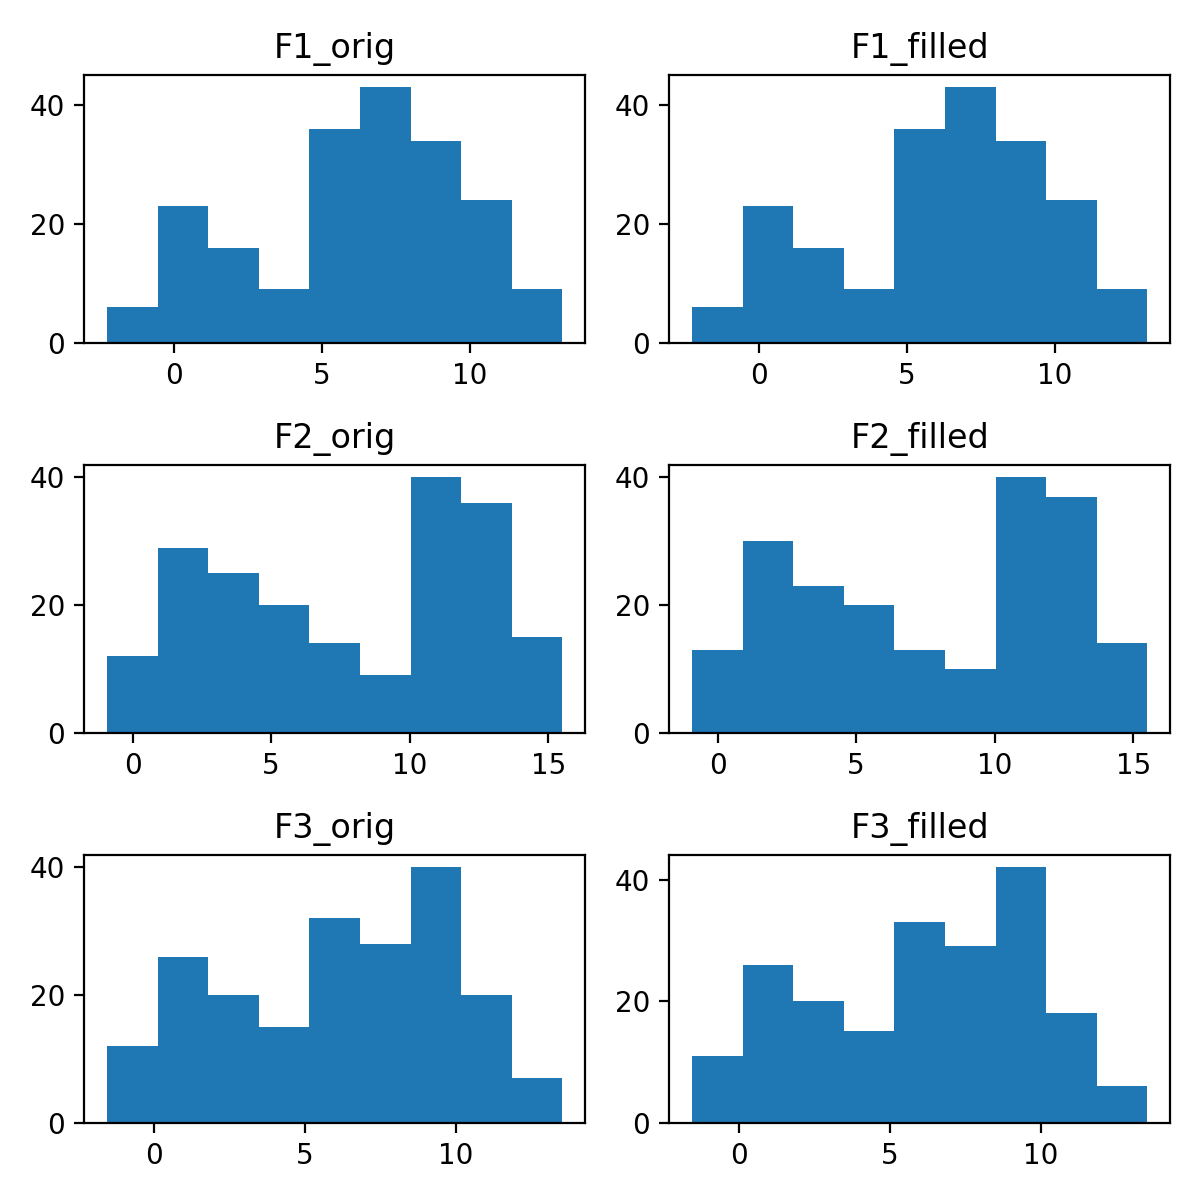

In [44]:
# plot distributions
bins = len(astropy.stats.freedman_bin_width(features[feature], return_bins=True)[1])
n_feat = len(features_best.columns)

fig, (ax) = plt.subplots(n_feat, 2, figsize=(n_feat*2,6))
for n, feature in enumerate(features_best.columns):
    ax[n, 0].hist(features[feature], bins=bins)
    ax[n, 0].set_title(f"{feature}_orig")
    ax[n, 1].hist(features_best[feature], bins=bins)
    ax[n, 1].set_title(f"{feature}_filled")

fig.tight_layout()
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "feature distributions.png"), **config["plots"])

#### 5.1.2 KL Divergence

In [45]:
# KL Divergence
def kl_divergence(feature1, feature2):
    
    # calculate probability distributions
    def probability_dist(x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(x, y, bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

    # calculate kl divergence
    bins = len(astropy.stats.freedman_bin_width(feature1, return_bins=True)[1])
    distr1, distr2 = probability_dist(feature1, feature2, bins)
    return torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()

In [46]:
output["kl_divergence"] = {}

# save kl divergence
for run in range(config["RQ2"]["runs"]):
    output["kl_divergence"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        output["kl_divergence"][f"run_{run}"][str(experiment_value)] = {}
        for feature in features_to_predict:
            output["kl_divergence"][f"run_{run}"][str(experiment_value)][feature] = kl_divergence(features[feature], features_reconstr[run][i][feature])

<IPython.core.display.Javascript object>


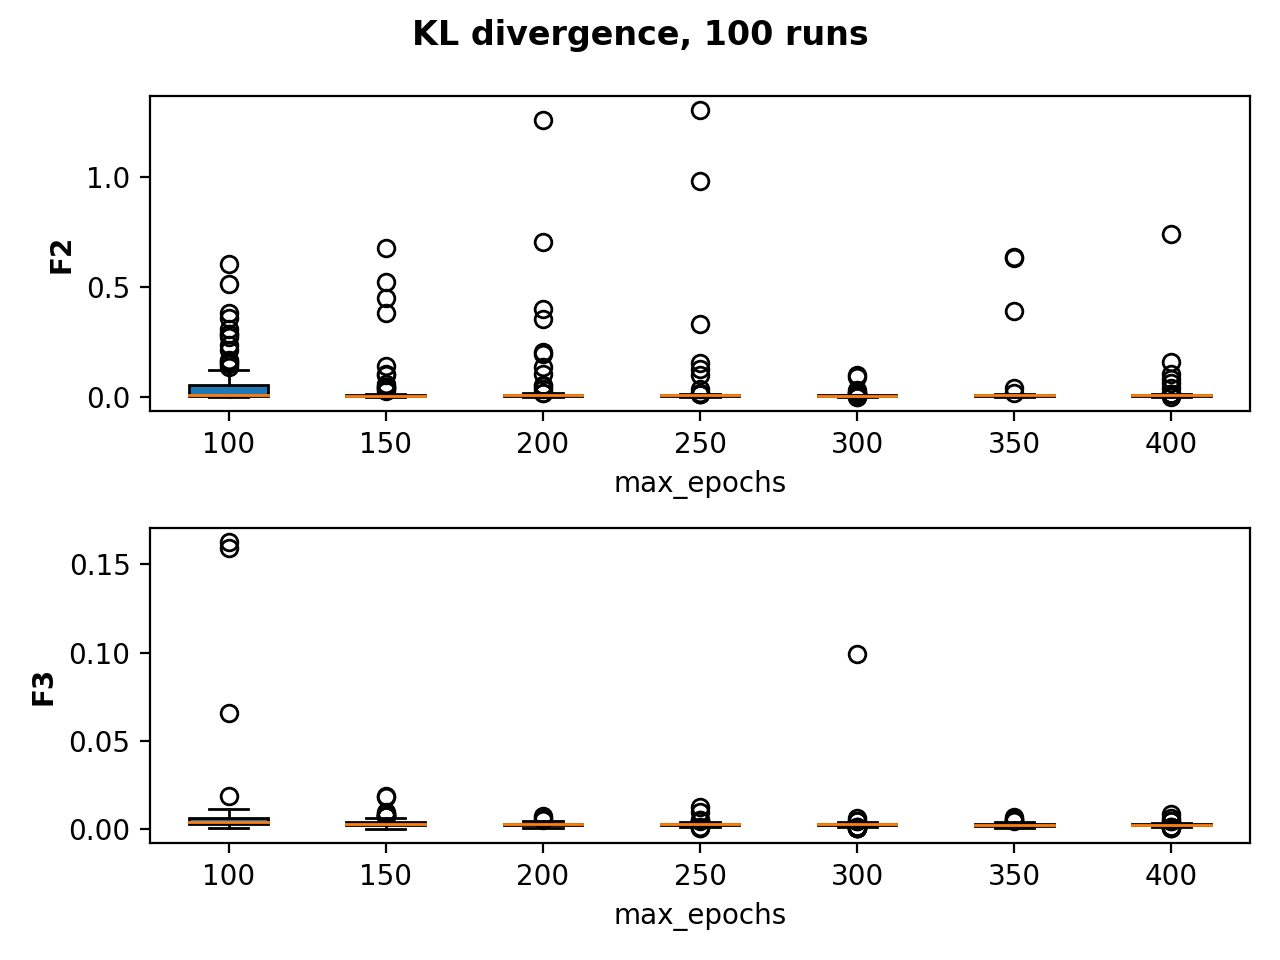

In [47]:
# plot
data = {}
for feature in features_to_predict:
    data[feature] = {}
    for experiment_value in experiment_variable_values:
        data[feature][str(experiment_value)] = [x[str(experiment_value)][feature] for x in output["kl_divergence"].values()]

nr_features = len(features_to_predict)
fig, axs = plt.subplots(nr_features)
fig.suptitle(f"KL divergence, {config['RQ2']['runs']} runs", fontweight='bold')

for nr, feature in enumerate(features_to_predict):
    axs[nr].boxplot(data[feature].values(), patch_artist = True) # , showfliers=False
    axs[nr].set_xticklabels(data[feature].keys())
    axs[nr].set_xlabel(config["general"]["experiment_variable"])
    axs[nr].set_ylabel(feature, fontweight='bold')

plt.tight_layout() 
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "5_kl_divergence.png"), **config["plots"])

### 5.2 Silhouette Score

In [48]:
from sklearn.metrics import silhouette_score

output["silhouette_scores"] = {}
output["silhouette_scores"]["orig_data"] = float(silhouette_score(features, np.ravel(clusters)))

for run in range(config["RQ2"]["runs"]):
    output["silhouette_scores"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        if len(np.unique(clusters_reconstr[run][i])) > 1:
            output["silhouette_scores"][f"run_{run}"][str(experiment_value)] = float(silhouette_score(features_reconstr[run][i], clusters_reconstr[run][i]))
        else:
            output["silhouette_scores"][f"run_{run}"][str(experiment_value)] = np.nan

<IPython.core.display.Javascript object>


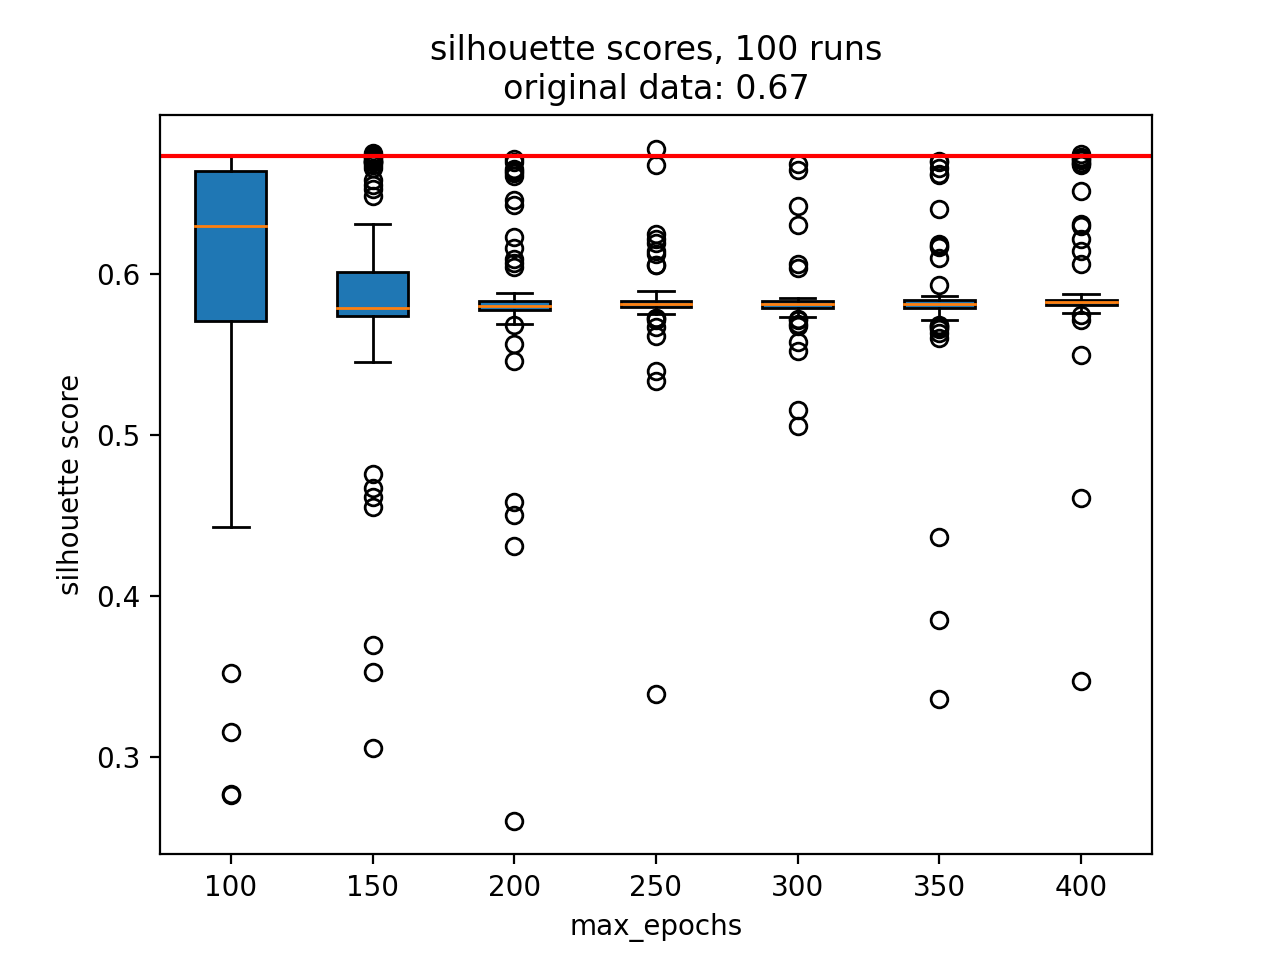

In [49]:
# plot
sil_scores = output["silhouette_scores"].copy()
del(sil_scores["orig_data"])

data = {}
for experiment_value in experiment_variable_values:
    data[str(experiment_value)] = [x[str(experiment_value)] for x in sil_scores.values()]

fig, ax = plt.subplots()
ax.boxplot(data.values(), patch_artist = True)
ax.set_xticklabels(data.keys())
plt.axhline(y=output['silhouette_scores']['orig_data'], color='r', linestyle='-')
plt.xlabel(config["general"]["experiment_variable"])
plt.ylabel("silhouette score")
plt.title(f"silhouette scores, {config['RQ2']['runs']} runs\noriginal data: {round(output['silhouette_scores']['orig_data'], 2)}")
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "5_silhouette_scores.png"), **config["plots"])

### 5.3. Outlierness
#### 5.3.1 Global outliers (considering all features)

In [51]:
# Outliers detected as noise by DBSCAN
output["cluster_noise"] = {}
output["cluster_noise"][f"orig_data"] = sum(clusters_orig == -1)

for run in range(config["RQ2"]["runs"]):
    output["cluster_noise"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        output["cluster_noise"][f"run_{run}"][str(experiment_value)] = sum(clusters_reconstr[run][i] == -1)

<IPython.core.display.Javascript object>


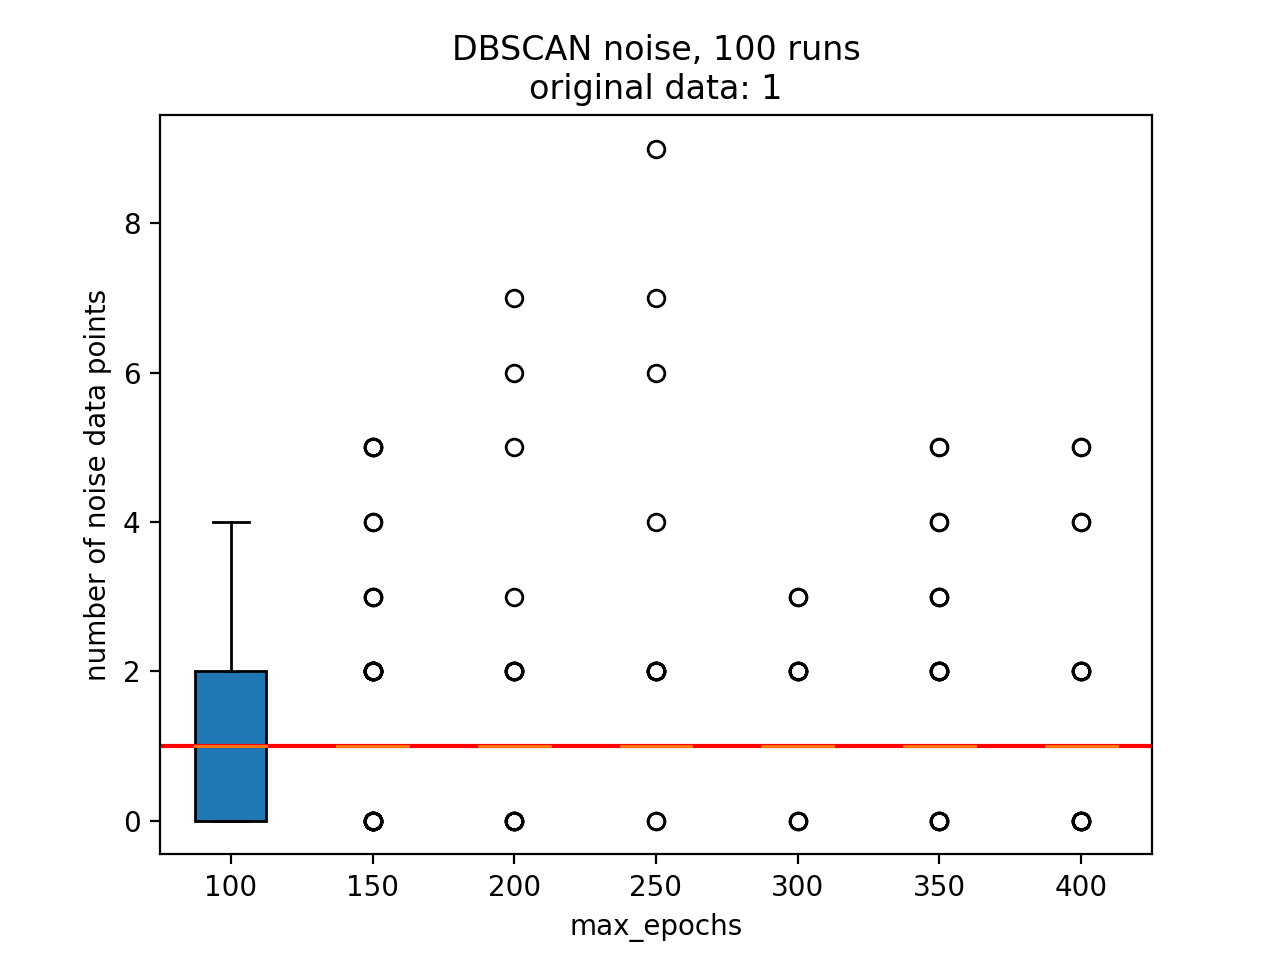

In [52]:
# plot
noise = output["cluster_noise"].copy()
del(noise["orig_data"])

data = {}
for experiment_value in experiment_variable_values:
    data[str(experiment_value)] = [x[str(experiment_value)] for x in noise.values()]

fig, ax = plt.subplots()
ax.boxplot(data.values(), patch_artist = True)
ax.set_xticklabels(data.keys())
plt.axhline(y=output["cluster_noise"]['orig_data'], color='r', linestyle='-')
plt.xlabel(config["general"]["experiment_variable"])
plt.ylabel("number of noise data points")
plt.title(f"DBSCAN noise, {config['RQ2']['runs']} runs\noriginal data: {output['cluster_noise']['orig_data']}")
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "5_DBSCAN-noise.png"), **config["plots"])

### 5.4. Save Output

In [53]:
if save_output:
    with open(output_path, "w") as f:
                toml.dump(output, f)